**Step 1: Load the Dataset and Perform EDA**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('/content/ticket_helpdesk_labeled_multi_languages_english_spain_french_german.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   queue                200 non-null    object
 1   priority             200 non-null    int64 
 2   software_used        83 non-null     object
 3   hardware_used        66 non-null     object
 4   accounting_category  51 non-null     object
 5   language             200 non-null    object
 6   subject              200 non-null    object
 7   text                 200 non-null    object
dtypes: int64(1), object(7)
memory usage: 12.6+ KB
None


In [4]:
print(df.head())

        queue  priority software_used   hardware_used  \
0    Hardware         2           NaN  Wireless Mouse   
1    Hardware         2           NaN          IP PBX   
2    Hardware         2           NaN    SFX-Netzteil   
3  Accounting         2           NaN             NaN   
4    Software         2      Arbitrum             NaN   

                     accounting_category language  \
0                                    NaN       en   
1                                    NaN       fr   
2                                    NaN       de   
3  Customer Inquiries::Technical Support       en   
4                                    NaN       en   

                                 subject  \
0  Wireless Mouse suddenly stops working   
1          Problème de connexions IP PBX   
2        Problem mit meinem SFX-Netzteil   
3             Invoice Adjustment Request   
4    Issue with Arbitrum: UI not loading   

                                                text  
0  Dear Support Te

In [6]:
df.columns

Index(['queue', 'priority', 'software_used', 'hardware_used',
       'accounting_category', 'language', 'subject', 'text'],
      dtype='object')

In [8]:
df.shape

(200, 8)

In [10]:
# Statistical summary of the dataset
print(df.describe())

         priority
count  200.000000
mean     2.195000
std      0.781041
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      3.000000


In [11]:
# Check for missing values
print(df.isnull().sum())

queue                    0
priority                 0
software_used          117
hardware_used          134
accounting_category    149
language                 0
subject                  0
text                     0
dtype: int64


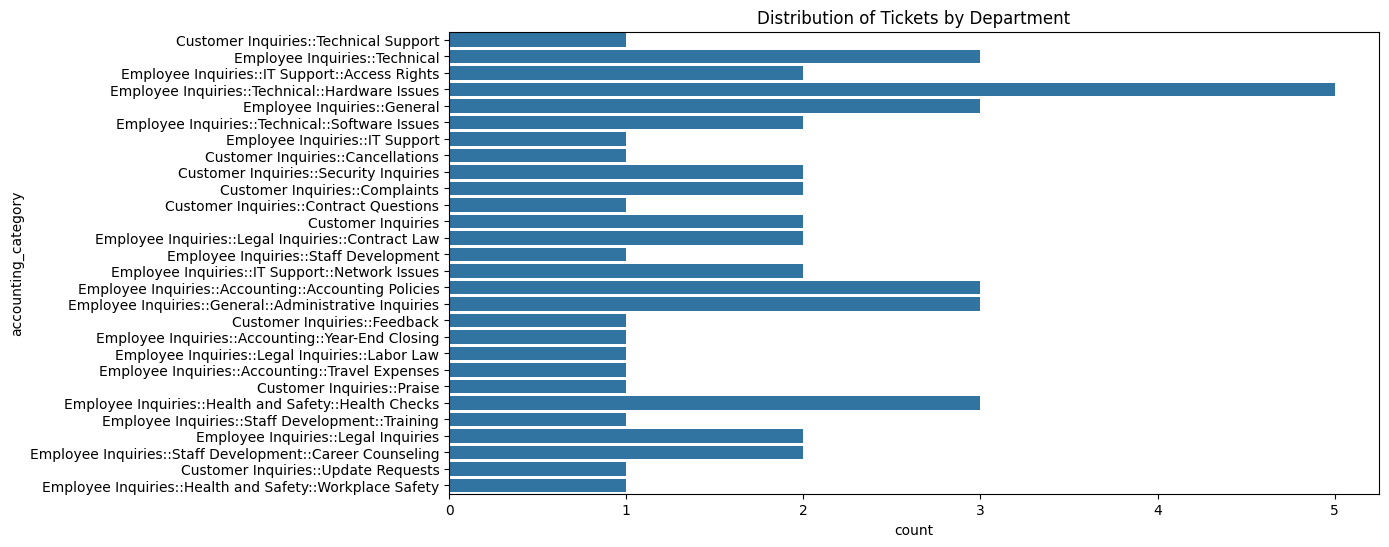

In [13]:
# Visualize the distribution of tickets across different categories
plt.figure(figsize=(12, 6))
sns.countplot(y='accounting_category', data=df)
plt.title('Distribution of Tickets by Department')
plt.show()

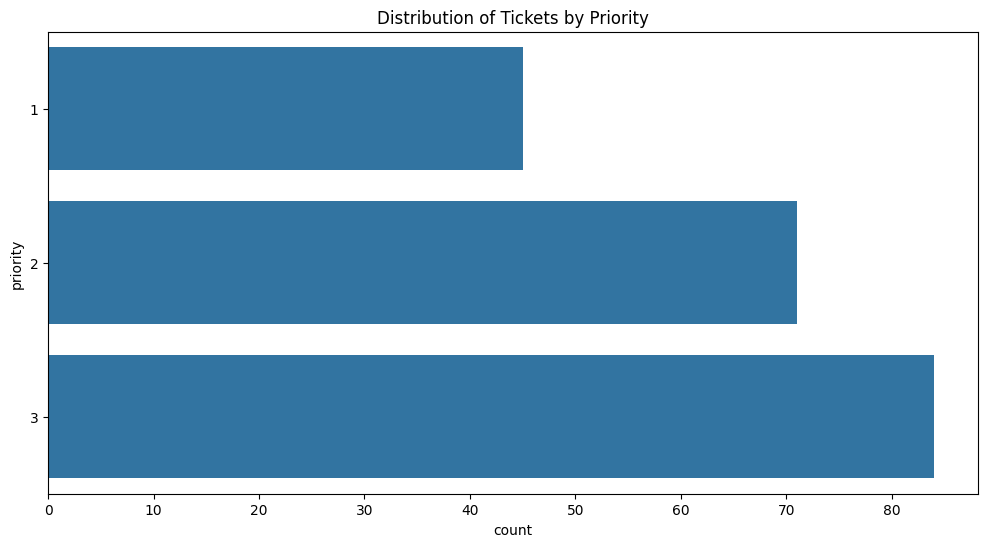

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(y='priority', data=df)
plt.title('Distribution of Tickets by Priority')
plt.show()

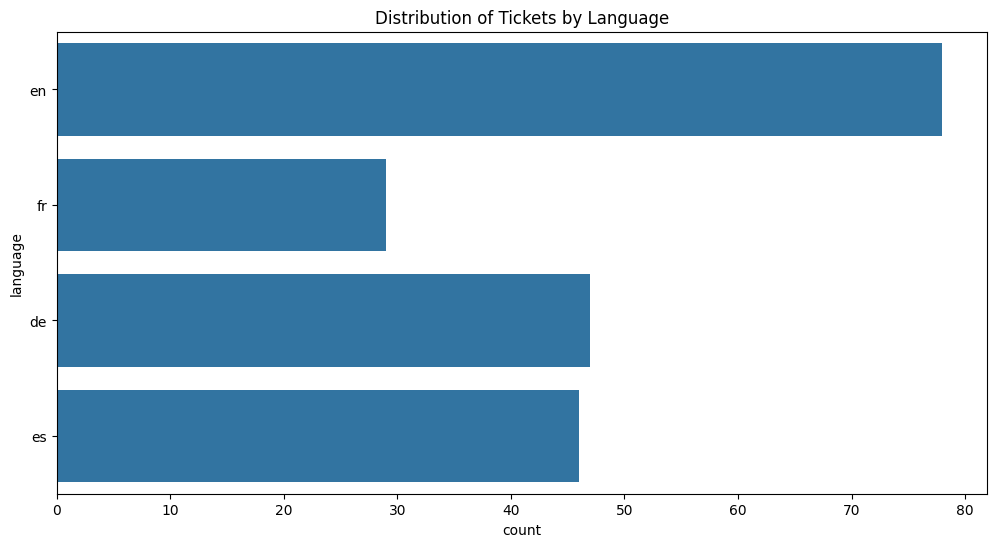

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(y='language', data=df)
plt.title('Distribution of Tickets by Language')
plt.show()

**Step 2: Splitting the Dataset**

In [16]:
from sklearn.model_selection import train_test_split

In [20]:
# Assuming the target variable is 'accounting_category' for classification
X = df['text']
y = df['accounting_category']

In [21]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Display the shapes of the train and test sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (160,), X_test shape: (40,)
y_train shape: (160,), y_test shape: (40,)


**Step 3: Data Preprocessing**

**For preprocessing, I will use tokenization and TF-IDF vectorization for classical machine learning models. For LSTM, I'll use tokenization and padding.**

**Preprocessing for Classical Machine Learning Models**


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

In [25]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [26]:
# Display the shape of the transformed data
print(f"X_train_tfidf shape: {X_train_tfidf.shape}, X_test_tfidf shape: {X_test_tfidf.shape}")

X_train_tfidf shape: (160, 2001), X_test_tfidf shape: (40, 2001)


**Preprocessing for LSTM**

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [28]:
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [29]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
maxlen = 100  # you can choose a suitable max length based on EDA
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [30]:
# Display the shape of the padded sequences
print(f"X_train_pad shape: {X_train_pad.shape}, X_test_pad shape: {X_test_pad.shape}")

X_train_pad shape: (160, 100), X_test_pad shape: (40, 100)


**LSTM Model**

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical # Import from tensorflow.keras instead
from sklearn.preprocessing import LabelEncoder

In [34]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))

# Handle unseen labels in y_test
y_test_transformed = []
for label in y_test:
    try:
        transformed_label = label_encoder.transform([label])[0]
    except ValueError:
        # Handle the unseen label (e.g., assign a default value)
        transformed_label = -1  # Or any other suitable handling
    y_test_transformed.append(transformed_label)

y_test_encoded = to_categorical(y_test_transformed)

In [35]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [36]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_encoded))

Epoch 1/5
3/3 [==============================] - 5s 559ms/step - loss: 3.2884 - accuracy: 0.2000 - val_loss: 3.2515 - val_accuracy: 0.8250
Epoch 2/5
3/3 [==============================] - 1s 431ms/step - loss: 3.2342 - accuracy: 0.7312 - val_loss: 3.1670 - val_accuracy: 0.8250
Epoch 3/5
3/3 [==============================] - 2s 591ms/step - loss: 3.1285 - accuracy: 0.7375 - val_loss: 2.9289 - val_accuracy: 0.8250
Epoch 4/5
3/3 [==============================] - 2s 550ms/step - loss: 2.7821 - accuracy: 0.7375 - val_loss: 1.4342 - val_accuracy: 0.8250
Epoch 5/5
3/3 [==============================] - 1s 314ms/step - loss: 1.5478 - accuracy: 0.7375 - val_loss: 1.1531 - val_accuracy: 0.8250


In [38]:
# Evaluate the model
score = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test Accuracy: {score[1]}")

2/2 [==============================] - 0s 29ms/step - loss: 1.1531 - accuracy: 0.8250
Test Accuracy: 0.824999988079071


In [39]:
# Predict results
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test_encoded.argmax(axis=-1)

2/2 [==============================] - 1s 45ms/step


In [42]:
# Display the classification report
from sklearn.metrics import classification_report

# Get the unique classes from both true and predicted labels
all_classes = set(y_test_classes.tolist() + y_pred_classes.tolist())

# Generate target names for all unique classes, ensuring they are strings
target_names = [str(label_encoder.classes_[i]) for i in all_classes] # Convert to string

print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

                                                       precision    recall  f1-score   support

                       Customer Inquiries::Complaints       0.00      0.00      0.00         1
               Customer Inquiries::Security Inquiries       0.00      0.00      0.00         1
Employee Inquiries::General::Administrative Inquiries       0.00      0.00      0.00         1
       Employee Inquiries::Technical::Hardware Issues       0.00      0.00      0.00         3
       Employee Inquiries::Technical::Software Issues       0.00      0.00      0.00         1
                                                  nan       0.82      1.00      0.90        33

                                             accuracy                           0.82        40
                                            macro avg       0.14      0.17      0.15        40
                                         weighted avg       0.68      0.82      0.75        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SGD Model**

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [45]:
# Train the SGD model
sgd = SGDClassifier(random_state=42)

# Check if y_train contains any NaN values and handle them
if y_train.isnull().any():
    # Option 1: Remove rows with NaN values (if applicable)
    # y_train = y_train.dropna()
    # X_train_tfidf = X_train_tfidf[y_train.index] # Adjust X_train_tfidf accordingly

    # Option 2: Replace NaN values with a suitable strategy (e.g., most frequent value)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='most_frequent')
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()

sgd.fit(X_train_tfidf, y_train)

SGDClassifier(random_state=42)

In [49]:
# Import necessary library for label encoding
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on both the training and testing labels combined
all_labels = np.concatenate((y_train, y_test))
label_encoder.fit(all_labels)  # Fit on all unique labels

# Transform both training and testing labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the SGD model using the encoded labels
sgd.fit(X_train_tfidf, y_train_encoded)

# Evaluate the model using encoded labels
y_pred_encoded = sgd.predict(X_test_tfidf)
print(f"SGD Accuracy: {sgd.score(X_test_tfidf, y_test_encoded)}")

SGD Accuracy: 0.0


In [51]:
# Display the classification report using encoded labels
print(classification_report(y_test_encoded, y_pred_encoded))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       0.0
          21       0.00      0.00      0.00       1.0
          26       0.00      0.00      0.00       3.0
          27       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00      31.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**KNN Model**

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [55]:
# Check the unique values in y_test to identify potential issues
print(y_test.unique())

# If y_test contains strings, encode them using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# Now evaluate the model using the encoded labels
y_pred = knn.predict(X_test_tfidf)
print(f"KNN Accuracy: {knn.score(X_test_tfidf, y_test_encoded)}")

['Employee Inquiries::Legal Inquiries::Labor Law' nan
 'Customer Inquiries::Security Inquiries'
 'Employee Inquiries::General::Administrative Inquiries'
 'Employee Inquiries::Technical::Hardware Issues'
 'Employee Inquiries::Accounting::Year-End Closing'
 'Employee Inquiries::Technical::Software Issues'
 'Customer Inquiries::Complaints']
KNN Accuracy: 0.0


In [61]:
# Check the unique values in y_test to identify potential issues
print(y_test.unique())

# If y_test contains strings, encode them using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.astype(str)) # Convert y_train to strings before encoding

# Get all the labels from both train and test data as strings
all_labels = np.unique(np.concatenate((y_train.astype(str), y_test.astype(str)), axis=0))

# Refit the label encoder with all the labels
le.classes_ = all_labels
y_test_encoded = le.transform(y_test.astype(str)) # Convert y_test to strings before encoding

# Train the KNN model using the encoded training labels
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train_encoded) # Use encoded y_train

# Now evaluate the model using the encoded labels
y_pred = knn.predict(X_test_tfidf)
print(f"KNN Accuracy: {knn.score(X_test_tfidf, y_test_encoded)}")

# No need to encode y_pred again as the model is already trained on encoded labels
print(classification_report(y_test_encoded, y_pred)) # Use the encoded y_test and y_pred

['Employee Inquiries::Legal Inquiries::Labor Law' nan
 'Customer Inquiries::Security Inquiries'
 'Employee Inquiries::General::Administrative Inquiries'
 'Employee Inquiries::Technical::Hardware Issues'
 'Employee Inquiries::Accounting::Year-End Closing'
 'Employee Inquiries::Technical::Software Issues'
 'Customer Inquiries::Complaints']
KNN Accuracy: 0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       0.0
          21       0.00      0.00      0.00       1.0
          26       0.00      0.00      0.00       3.0
          27       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**K Means Clustering**

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [64]:
# Train the K Means model
kmeans = KMeans(n_clusters=len(df['accounting_category'].unique()), random_state=42)
kmeans.fit(X_train_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=29, random_state=42)

In [65]:
# Predict the clusters
y_pred = kmeans.predict(X_test_tfidf)

In [70]:
# Check for NaNs in y_test
print(y_test.isnull().any())

# If there are NaNs, handle them.
# Here's one approach - removing samples with NaNs in y_test:
valid_indices = ~y_test.isnull()
y_test_valid = y_test[valid_indices]
y_pred_valid = y_pred[valid_indices]

# Evaluate the model using the valid data
print(f"Adjusted Rand Index: {adjusted_rand_score(y_test_valid, y_pred_valid)}")

True
Adjusted Rand Index: 0.2727272727272727


**XGBoost Model**

In [75]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Fit the model with encoded labels
xgb_model.fit(X_train_tfidf, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [78]:
# Evaluate the model
y_pred = xgb_model.predict(X_test_tfidf)

# Decode integer predictions back to original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Ensure both arrays are of the same data type (string)
y_test = y_test.astype(str)
y_pred_decoded = y_pred_decoded.astype(str)

# Now compare the decoded predictions with the original string labels in y_test
accuracy = accuracy_score(y_test, y_pred_decoded)
print(f"XGBoost Accuracy: {accuracy}")

XGBoost Accuracy: 0.0


In [80]:
# Display the classification report
print(classification_report(y_test, y_pred_decoded))

                                                       precision    recall  f1-score   support

                       Customer Inquiries::Complaints       0.00      0.00      0.00       1.0
               Customer Inquiries::Security Inquiries       0.00      0.00      0.00       1.0
  Employee Inquiries::Accounting::Accounting Policies       0.00      0.00      0.00       0.0
     Employee Inquiries::Accounting::Year-End Closing       0.00      0.00      0.00       1.0
Employee Inquiries::General::Administrative Inquiries       0.00      0.00      0.00       1.0
       Employee Inquiries::Legal Inquiries::Labor Law       0.00      0.00      0.00       1.0
       Employee Inquiries::Technical::Hardware Issues       0.00      0.00      0.00       3.0
       Employee Inquiries::Technical::Software Issues       0.00      0.00      0.00       1.0
                                                  nan       0.00      0.00      0.00      31.0

                                             acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**SVM Model**

In [81]:
from sklearn.svm import SVC

In [82]:
# Train the SVM model
svm = SVC(random_state=42)
svm.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [83]:
# Evaluate the model
y_pred = svm.predict(X_test_tfidf)
print(f"SVM Accuracy: {svm.score(X_test_tfidf, y_test)}")

SVM Accuracy: 0.0


In [84]:
# Display the classification report
print(classification_report(y_test, y_pred))

                                                       precision    recall  f1-score   support

                       Customer Inquiries::Complaints       0.00      0.00      0.00       1.0
               Customer Inquiries::Security Inquiries       0.00      0.00      0.00       1.0
  Employee Inquiries::Accounting::Accounting Policies       0.00      0.00      0.00       0.0
     Employee Inquiries::Accounting::Year-End Closing       0.00      0.00      0.00       1.0
Employee Inquiries::General::Administrative Inquiries       0.00      0.00      0.00       1.0
       Employee Inquiries::Legal Inquiries::Labor Law       0.00      0.00      0.00       1.0
       Employee Inquiries::Technical::Hardware Issues       0.00      0.00      0.00       3.0
       Employee Inquiries::Technical::Software Issues       0.00      0.00      0.00       1.0
                                                  nan       0.00      0.00      0.00      31.0

                                             acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.